In [1]:
%matplotlib inline
from tensorscaling import scale, unit_tensor, random_tensor, marginal
import numpy as np
import matplotlib.pyplot as plt

# Tensor scaling

Scale 3x3x3 unit tensor to certain non-uniform marginals:

In [ ]:
shape = [3, 3, 3]
targets = [(.5, .25, .25), (.4, .3, .3), (.7, .2, .1)]

res = scale(unit_tensor(3, 3), targets, eps=1e-4)
res

We can also access the scaling matrices and the final scaled state:

In [ ]:
print(res.gs[0], "\n")
print(res.gs[1], "\n")
print(res.gs[2])

Let's now check that the W tensor *cannot* be scaled to uniform marginals:

In [ ]:
shape = [2, 2, 2, 2]
W = np.zeros(shape)
W[1, 0, 0, 0] = W[0, 1, 0, 0] = W[0, 0, 1, 0] = W[0, 0, 0, 1] = .5
targets = [(.5, .5)] * 4

scale(W, targets, eps=1e-4, max_iterations=1000)

To see more clearly what is going on, we can set the `verbose` flag:

In [ ]:
res = scale(W, targets, eps=1e-4, max_iterations=10, verbose=True)

We see that at each point in the algorithm, one of the marginals has Frobenius distance $\approx 0.59$ to being uniform. Indeed, we know that the entanglement polytope of the W tensor does not include the point corresponding to uniform marginals -- see [here](https://www.entanglement-polytopes.org/four_qubits) for an interactive visualization!

# Tuples of matrices and tensors

We can just as well only prescribe the desired spectra for subsystems.
Note that prescribing two out of three marginals amounts to *operator scaling*.

In [ ]:
shape = [3, 3, 3]
targets = [(.4, .3, .3), (.7, .2, .1)]

res = scale(unit_tensor(3, 3), targets, eps=1e-6)
res

Indeed, the last two marginals are as prescribed, while the first marginal is arbitrary.

In [ ]:
print(marginal(res.psi, 0).round(5), "\n")
print(marginal(res.psi, 1).round(5), "\n")
print(marginal(res.psi, 2).round(5))

# Gradient descent 

In [2]:


def rand_3tensor_unif(n):
    start = random_tensor([n,n,n])
    targets = [np.ones(n)/n,np.ones(n)/n,np.ones(n)/n]
    res, norms, frobs = scale(start, targets, eps=1e-4, method = "gradient")
    lognorm = []
    for norm in norms:
        lognorm.append(np.log(norm))
        #norm = np.log(norm)
    return lognorm

In [3]:
def rand_3tensor_ratio(n):
    start = random_tensor([n,n,n])
    targets = [np.ones(n)/n,np.ones(n)/n,np.ones(n)/n]
    res, norms, frobs = scale(start, targets, eps=1e-4, method = "gradient")
    ratios = []
    #lognorms = []
    #logfrobs = []
    for i in range(len(norms)):
        ratios.append(norms[i]**2/(frobs[i]**2))
        #lognorms.append(np.log(norms[i]-(1/n)))
        #logfrobs.append(np.log(frobs[i]))
        #norm = np.log(norm)
    return ratios, frobs, norms

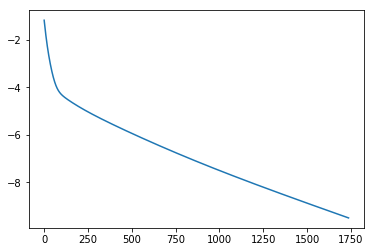

In [4]:
#plots log of (spectral norm -1) of the first marginal
norms = rand_3tensor_unif(3)
plt.plot(norms)

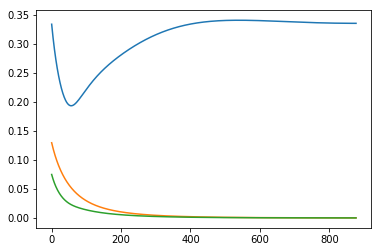

In [12]:
ratios, frobs, norms = rand_3tensor_ratio(8)
plt.plot(ratios)
plt.plot(frobs)
plt.plot(norms)

In [ ]:
np.linalg.eigvalsh(np.matrix([[1,0],[0,2]]))